In [1]:
import os
import cv2
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter

import torchvision
from torchvision.utils import save_image
from torchvision.io import read_image
import torchvision.transforms as T

In [84]:
image_path1 = r'C:\\Users\\H_JOLLY\\Downloads\\images\\train\\100850.jpg'

image = Image.open(image_path1)
image = np.array(image)
print("PIL - ", image.shape)

img = io.imread(image_path1)
print("Skimage - ", img.shape)

PIL -  (424, 600, 3)
Skimage -  (424, 600, 3)


## Bilateral Filtering

In [72]:
#Loading Image Function
def load_image(pathofImage, isGray=True):
    image = io.imread(pathofImage)
    gray = lab = rgb = None
    
    if(len(image.shape)==2):
        gray = image
    elif len(image.shape)>=3:
        lab = color.rgb2lab(image)
        rgb = (color.lab2rgb(lab)*255).astype(np.uint8)
        gray = (color.rgb2gray(image)*255).astype(int)
    else:
        print('_____Image shape not allowed_____')
    
    if isGray:
        return gray
    else:
        return image, lab

In [67]:
#Matrix values with respect to intensity values of the neighbouring pixels
def similatiry_matrix(center_value, window_values, sigma_r, gray_img):
    matrix = np.full(window_values.shape, center_value)
    
    if gray_img:
        d_matrix = np.absolute(window_values-matrix)
    else:
        d_matrix = np.linalg.norm(window_values-matrix, axis=2)
    
    return np.exp((-0.5)*((d_matrix**2/sigma_r**2)))

In [68]:
#Matrix values with respect to closeness of the neighbouring pixels in spatial domain
def spatial_kernel(size, sigma):
    kernel = np.empty((size,size))
    c_x = int(size/2)
    c_y = int(size/2)

    for i in range(size):
        for j in range(size):
            d = distance.euclidean([j, i], [c_x, c_y])
            kernel[j, i] = np.exp((-0.5)*((d**2/sigma**2)))
            
    return kernel

In [69]:
#Filtering the image using similarity matrix and spatial kernal
def bilateral_filter(img, sigma_d, sigma_r, window_size=7):
    height = img.shape[1]
    length = img.shape[0]
    half_wsize = int(window_size/2)
    
    is_gray=None
    if (len(img.shape)==3):
        is_gray=False
    elif (len(img.shape)==2):
        is_gray=True
    
    C_matrix = spatial_kernel(window_size, sigma_d)
    filtered_img = np.zeros(img.shape)
    
    for y in range(height):
        y_low  = max(y-half_wsize, 0)
        y_high = min(y+half_wsize+1, height)
        for x in range(length):
            x_low  = max(x-half_wsize, 0)
            x_high = min(x+half_wsize+1, length)
            
            S_matrix = similatiry_matrix(img[x, y], img[x_low:x_high, y_low:y_high], sigma_r, is_gray)
            w_matrix = C_matrix[half_wsize-x+x_low:x_high-x+half_wsize, half_wsize-y+y_low:y_high-y+half_wsize] * \
                        S_matrix
            
            if not is_gray:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*np.stack((w_matrix,w_matrix,w_matrix), axis=2), axis=(0,1)) / np.sum(w_matrix))
            else:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*w_matrix) / np.sum(w_matrix)).astype(int)
            filtered_img[x, y] = filtered_pixel
            
    return filtered_img

In [77]:
#Bilateral filtering on a color image
image1_path = r'C:\\Users\\H_JOLLY\\Downloads\\images\\train\\155920.jpg'
   
def apply_bilateral_filter(image_path):
    rgb, lab = load_image(image_path, False)
    filteredimagelab = bilateral_filter(lab, sigma_d=3, sigma_r=3, window_size=9)
    # print(type(filteredimagelab)) 
    return filteredimagelab

apply_bilateral_filter(image1_path)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

(-0.5, 319.5, 259.5, -0.5)

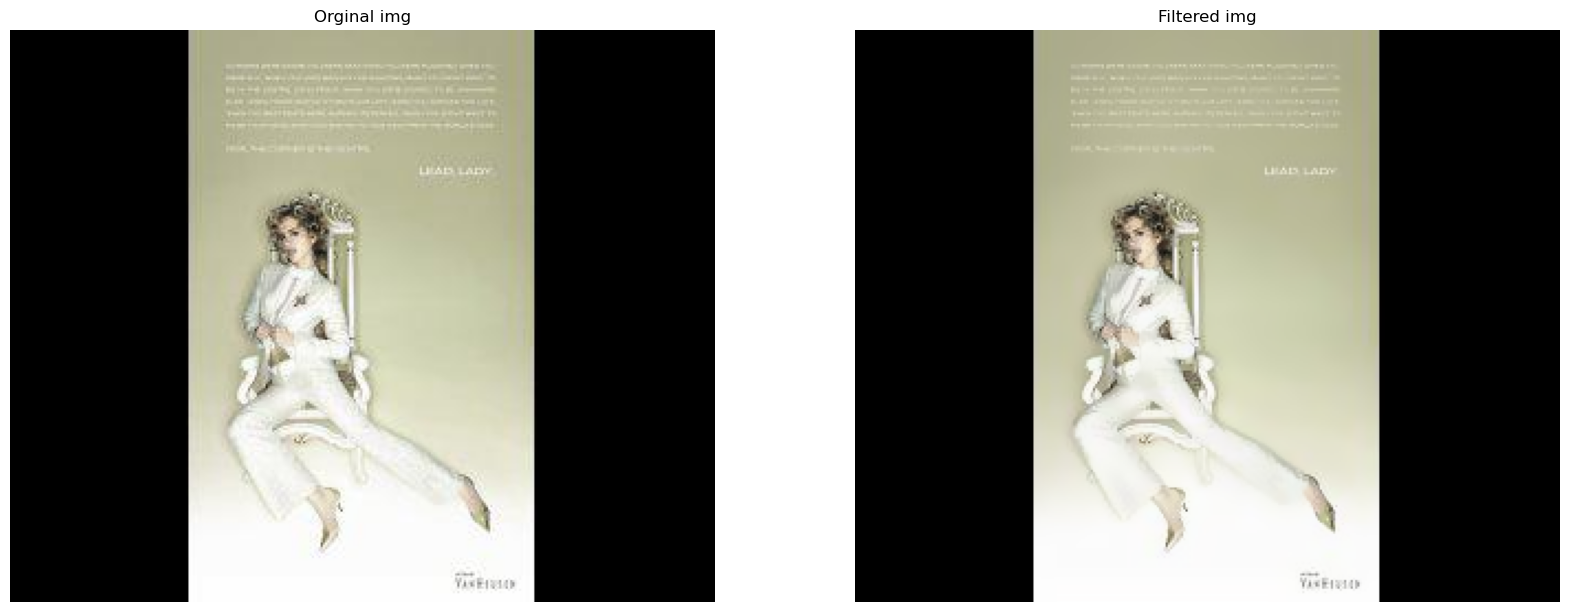

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax1.set_title("Orginal img")
ax1.imshow(rgb)
ax1.axis('off')
ax2.set_title("Filtered img")
ax2.imshow((color.lab2rgb(filteredimagelab)*255).astype(np.uint8))
ax2.axis('off')

## Bilateral Filter using OpenCV

In [ ]:
images_path = ["C:\\Users\\H_JOLLY\\Downloads\\images\\train\\100850.jpg", "C:\\Users\\H_JOLLY\\Downloads\\images\\train\\56530.jpg", 
               "C:\\Users\\H_JOLLY\\Downloads\\images\\train\\177748.png"]

In [109]:
def bilateral_using_cv(img):
    
    bilateral = cv2.bilateralFilter(img, 9, 9, 9)
    bilateral = cv2.bilateralFilter(bilateral, 9, 9, 9)
    return bilateral

In [136]:
image1_path = 'C:\\Users\\H_JOLLY\Downloads\\images\\train\\162282.jpg'
image2_path = 'C:\\Users\\H_JOLLY\Downloads\\images\\train\\94511.jpg'
image3_path = 'C:\\Users\\H_JOLLY\Downloads\\images\\train\\81832.jpg'

img1 = cv2.imread(image1_path)
print(img1.shape)
bilateral_img1 = bilateral_using_cv(img1)
img2 = cv2.imread(image2_path)
print(img2.shape)
bilateral_img2 = bilateral_using_cv(img2)
img3 = cv2.imread(image3_path)
print(img3.shape)
bilateral_img3 = bilateral_using_cv(img3)

(360, 480, 3)
(260, 320, 3)
(260, 320, 3)


[]

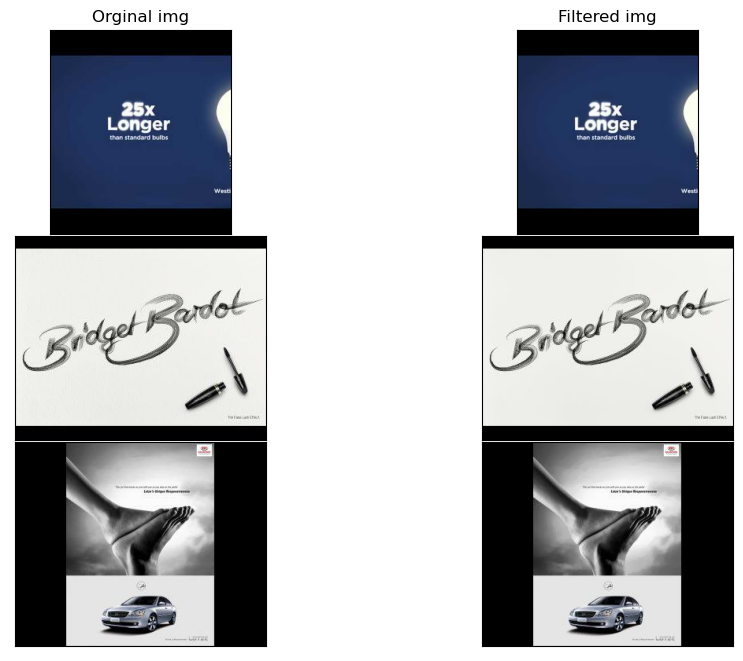

In [138]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2, hspace=0.01, wspace=0.01)
(ax1,ax2), (ax3,ax4), (ax5, ax6) = gs.subplots(sharey='row', sharex='col')

ax1.set_title("Orginal img")
ax2.set_title("Filtered img")

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(bilateral_img1, cv2.COLOR_BGR2RGB))

ax3.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(bilateral_img2, cv2.COLOR_BGR2RGB))

ax5.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax6.imshow(cv2.cvtColor(bilateral_img3, cv2.COLOR_BGR2RGB))

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_xticklabels([])

ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_yticklabels([])
ax5.set_xticklabels([])

ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_yticklabels([])
ax6.set_xticklabels([])